In [1]:
import gensim.downloader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from gensim.models import KeyedVectors
from keras.layers import Dense, Flatten, LSTM, GRU, Bidirectional, Embedding
from keras.models import Sequential
from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, classification_report
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('data\preprocessed.csv').dropna()
nlp = spacy.load("en_core_web_sm")
#glove = gensim.downloader.load('glove-twitter-200')
#glove.save("glove.model")
glove = KeyedVectors.load("glove.model")

In [3]:
words = list(glove.key_to_index.keys())
embeddings_index = {}
for word in words:    
    coefs = np.asarray(glove[word], dtype='float32')
    embeddings_index[word] = coefs
print(len(embeddings_index))

1193514


In [4]:
X = data["Reviews_cleaned"]
y = data["Category"]

In [5]:
maxlen = 10
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print(f"Znaleziono {len(word_index)} unikatowych tokenów.")
data_X = sequence.pad_sequences(sequences, maxlen=maxlen)
print(f"Kształt tensora danych: {data_X.shape}") 
print(f"Kształt tensora etykiet: {y.shape}")

Znaleziono 9691 unikatowych tokenów.
Kształt tensora danych: (40700, 10)
Kształt tensora etykiet: (40700,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [8]:
X_train.shape, X_test.shape, X.shape

((32560, 10), (8140, 10), (40700,))

In [9]:
embedding_dim = 200
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:            
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = glove['unk']

In [16]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 200)           2000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 128)           135680    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_split=0.2)
#model.save_weights('pre_trained_glove_model.h5')

Epoch 1/5
814/814 [==============================] - 44s 48ms/step - loss: 0.4776 - accuracy: 0.7801 - val_loss: 0.4506 - val_accuracy: 0.7990
Epoch 2/5
814/814 [==============================] - 38s 47ms/step - loss: 0.4468 - accuracy: 0.7976 - val_loss: 0.4482 - val_accuracy: 0.8042
Epoch 3/5
814/814 [==============================] - 38s 47ms/step - loss: 0.4343 - accuracy: 0.8052 - val_loss: 0.4426 - val_accuracy: 0.8007
Epoch 4/5
814/814 [==============================] - 38s 47ms/step - loss: 0.4235 - accuracy: 0.8125 - val_loss: 0.4426 - val_accuracy: 0.8007
Epoch 5/5
814/814 [==============================] - 38s 46ms/step - loss: 0.4132 - accuracy: 0.8178 - val_loss: 0.4403 - val_accuracy: 0.8005


In [18]:
y_pred = np.round(model.predict(X_test))
f1_score(y_test, y_pred)

0.8682730249349342

In [19]:
cohen_kappa_score(y_test, y_pred)

0.5130929334072432

In [20]:
def plot_history(history, key="loss"):
    metric = history.history[key]
    val_metric = history.history[f"val_{key}"]
    epochs = range(len(metric))
    plt.plot(epochs, metric, "bo", label=f"{key} - train")
    plt.plot(epochs, val_metric, "b", label=f"{key} - val")
    plt.title(f"training - {key}")
    plt.legend()
    plt.show()

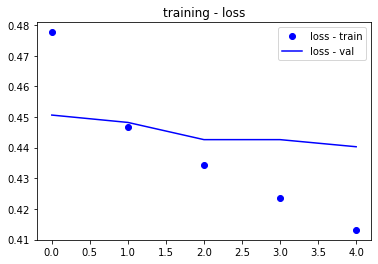

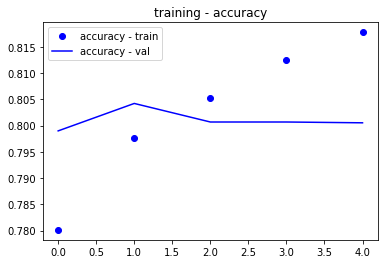

In [21]:
plot_history(history)
plot_history(history, key='accuracy')